#Скрытая марковская модель
**Текст задания**

Значения всех параметров (матрицы вероятностей, размерности и т.п.) должны определяться один раз, после чего для вычислений уже используются переменные. "Хардкодить"числа внутри кода не допускается.

* Для заданных матриц переходных вероятностей $A$ и эмиссионных вероятностей E сгенерировать последовательность $σ$ скрытых состояний и последовательность ε наблюдений длины $L$. В качестве начального распределения использовать стационарное распределение матрицы $A$ (собственный вектор, соответсвтующий единичному собственному значению).

* Реализовать алгоритм Витерби: для данных $A$, $E$ и $ε$ найти $σv =argmaxσ′P(σ′,ε|A,E)$.

  Визуализировать результат: построить на графике $σ$ и $σv$ (на оси $x$ - позиция, на оси $y$ - номер состояния).

* Реализовать алгоритмы прямого и обратного хода (особое внимание уделите инициализации алгоритмов!). Вычислить $P (ε)$ с помощью обоих алгоритмов.

* Реализовать апостериорное декодирование.
Визуализировать результат: построить график $P(state0|ε)(l)$.

* Реализовать алгоритм Баума-Велша.

Протестировать алгоритмы для $L = 100, 500, 1000$. Добавить защиту от потери точности через $logsumexp$ и/или нормализацию (см. учебник *Durbin et al*).


## Шаг 0. Казино (данные из учебника *Durbin et al*)
* **Последовательность наблюдений, $w$:**
315116246446644245311321631164152133625144543631656626566666651166453132651245636664631636663162326455236266666625151631222555441666566563564324364131513465146353411126414626253356366163666466232534413661661163252562462255265252266435353336233121625364414432335163243633665562466662632666612355245242

 > 1, 2, 3, 4, 5, 6 - числа на подбрасываемом кубике.
         
* **Последовательность скрытых состояний, $s$:**
FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFLLLLLLLLLLLLLLLLFFFLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFF

 > F (fair) - честных кубик,
 >
 > L (loaded) - подкрученный кубик.

Теоретическая справка:

* F (Fair): Состояние, когда кубик честный, т.е., каждое число от 1 до 6 имеет равную вероятность выпадения.
* L (Loaded): Состояние, когда используется подвинутый или несбалансированный кубик, который настроен так, чтобы некоторые числа выпадали чаще, чем другие.


In [ ]:
import numpy as np

In [ ]:
# создание списков
w = '315116246446644245311321631164152133625144543631656626566666651166453132651245636664631636663162326455236266666625151631222555441666566563564324364131513465146353411126414626253356366163666466232534413661661163252562462255265252266435353336233121625364414432335163243633665562466662632666612355245242'
s = 'FFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFFFLLLLLLLLLLLLLLLLFFFLLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFFLLLLLLLLLLLLLLLLLLLLLLFFFFFFFFFFF'
w = [int(number) for number in w]
w_given = [int(number) for number in w] # для отображения при проверке

s = list(s)
s_given = list(s) # для отображения при проверке

for i, symbol in enumerate(s):
    if s[i] == 'F':
        s[i] = 0
    else:
        s[i] = 1

# тут я делаю следующее: каждому выпавшему значению кубика присваиваю значение минус 1 (для работы алгоритма)
for j, number in enumerate(w):
    w[j] -= 1


print(f'Наблюдения:\n{w},\n\nСкрытые состояния:\n{s}')

Наблюдения:
[2, 0, 4, 0, 0, 5, 1, 3, 5, 3, 3, 5, 5, 3, 3, 1, 3, 4, 2, 0, 0, 2, 1, 0, 5, 2, 0, 0, 5, 3, 0, 4, 1, 0, 2, 2, 5, 1, 4, 0, 3, 3, 4, 3, 2, 5, 2, 0, 5, 4, 5, 5, 1, 5, 4, 5, 5, 5, 5, 5, 5, 4, 0, 0, 5, 5, 3, 4, 2, 0, 2, 1, 5, 4, 0, 1, 3, 4, 5, 2, 5, 5, 5, 3, 5, 2, 0, 5, 2, 5, 5, 5, 2, 0, 5, 1, 2, 1, 5, 3, 4, 4, 1, 2, 5, 1, 5, 5, 5, 5, 5, 5, 1, 4, 0, 4, 0, 5, 2, 0, 1, 1, 1, 4, 4, 4, 3, 3, 0, 5, 5, 5, 4, 5, 5, 4, 5, 2, 4, 5, 3, 2, 1, 3, 2, 5, 3, 0, 2, 0, 4, 0, 2, 3, 5, 4, 0, 3, 5, 2, 4, 2, 3, 0, 0, 0, 1, 5, 3, 0, 3, 5, 1, 5, 1, 4, 2, 2, 4, 5, 2, 5, 5, 0, 5, 2, 5, 5, 5, 3, 5, 5, 1, 2, 1, 4, 2, 3, 3, 0, 2, 5, 5, 0, 5, 5, 0, 0, 5, 2, 1, 4, 1, 4, 5, 1, 3, 5, 1, 1, 4, 4, 1, 5, 4, 1, 4, 1, 1, 5, 5, 3, 2, 4, 2, 4, 2, 2, 2, 5, 1, 2, 2, 0, 1, 0, 5, 1, 4, 2, 5, 3, 3, 0, 3, 3, 2, 1, 2, 2, 4, 0, 5, 2, 1, 3, 2, 5, 2, 2, 5, 5, 4, 4, 5, 1, 3, 5, 5, 5, 5, 1, 5, 2, 1, 5, 5, 5, 5, 0, 1, 2, 4, 4, 1, 3, 4, 1, 3, 1],

Скрытые состояния:
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

In [ ]:
N = len(np.unique(s))
K = len(np.unique(w))
L = len(s)

In [ ]:
# матрица переходов (из учебника, стр.54)
A = [[0.95, 0.05], [0.1, 0.9]]
A = np.array(A)

print(f'Матрица переходов:\n\n{A}')

Матрица переходов:

[[0.95 0.05]
 [0.1  0.9 ]]


In [ ]:
# эмиссионная матрица (из учебника, стр.54)

fair_P = [1/6] * 6

loaded_P = [0.1, 0.1, 0.1, 0.1, 0.1, 0.5]

E = []
E.append(fair_P)
E.append(loaded_P)
E = np.array(E)
print(f'Эмиссионная матрица:\n\n{E}')

Эмиссионная матрица:

[[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]]


In [ ]:
# Поиск стационарного распределения

eigvals, eigvecs = np.linalg.eig(A.T) # поиск собств. векторов и собствю значений
stationary_distribution = np.real(eigvecs[:, np.isclose(eigvals, 1)])
stationary_distribution = stationary_distribution / stationary_distribution.sum()

B = stationary_distribution.flatten()

print(f'Начальное распределение B: {B}')

Начальное распределение B: [0.66666667 0.33333333]


In [ ]:
# логаримфирование данных для работы с алгоритмами

A_log = np.log(A)
B_log = np.log(B)
E_log = np.log(E)

In [ ]:
print('\033[1mВХОДНЫЕ ДАННЫЕ\n\033[0m')
print(f'👾 \033[1mМатрица переходов, A:\n\033[0m {A} \n')
print(f'👾 \033[1mЭмиссионная матрица, E:\n\033[0m {E} \n')
print(f'👾 \033[1mНачальное распределение скрытых состояний B:\n\033[0m {B} \n')
print(f'👾 \033[1mСкрытые состояния:\n\033[0m {s} \n')
print(f'👾 \033[1mНаблюдения:\n\033[0m {w}')

ВХОДНЫЕ ДАННЫЕ

👾 Матрица переходов, A:
 [[0.95 0.05]
 [0.1  0.9 ]] 

👾 Эмиссионная матрица, E:
 [[0.16666667 0.16666667 0.16666667 0.16666667 0.16666667 0.16666667]
 [0.1        0.1        0.1        0.1        0.1        0.5       ]] 

👾 Начальное распределение скрытых состояний B:
 [0.66666667 0.33333333] 

👾 Скрытые состояния:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,

## Шаг 1. Генерация рандомных $A$, $E$, $B$, $s$, $w$
* $A$ - матрица переходов между скрытыми состояниями
* $E$ - эмиссионная матрица (по строкам - наблюдения, по столбцам - скрытые состояния)
* $B$ - начальное распределение (вероятности оказаться в том или ином скрытом состоянии на начльном этапе)
* $s$ - вектор скрытых состояний
* $w$ - вектор наблюдений
* $N$ - число уникальных скрытых состояний
* $K$ - число уникальных наблюдений
* $L$ - число всех наблюдений (время)

In [1]:
import numpy as np

In [2]:
# МОЖНО ПОМЕНЯТЬ ПЕРЕД ЗАПУСКОМ КОДА ПО ЖЕЛАНИЮ

N = 10 #число скрытых состояний (плохо, хорошо, терпимо)
K = 15 #число наблюдений (Саша, Вася, Петя, Миша)
L = 20 #число дней (записей в дневнике наблюдений и скрытых состояний)

In [3]:
# генерация вектора с суммой элементов = 1

def generate_stochastic_vector(n):
    vector = np.random.rand(n)
    vector /= vector.sum()
    return vector

In [4]:
A = []
for i in range(N):
    row = generate_stochastic_vector(N)
    A.append(row)
A = np.array(A)

E = []
for i in range(N):
    row = generate_stochastic_vector(K)
    E.append(row)
E = np.array(E)

In [5]:
'''
print(f'Матрица переходов, A:\n\n {A}\n\n')
print(f'Эмиссионная матрица, E:\n\n {E}')\
'''

"\nprint(f'Матрица переходов, A:\n\n {A}\n\n')\nprint(f'Эмиссионная матрица, E:\n\n {E}')"

Чат подсказывает: Стационарное распределение представляет собой долгосрочную, стабильную вероятность нахождения в каждом из состояний. В контексте скрытых марковских моделей, оно может использоваться как начальное распределение вероятностей состояний, если информацию о стартовом состоянии нет.

In [6]:
# Поиск стационарного распределения

eigvals, eigvecs = np.linalg.eig(A.T) # поиск собств. векторов и собствю значений
stationary_distribution = np.real(eigvecs[:, np.isclose(eigvals, 1)])
stationary_distribution = stationary_distribution / stationary_distribution.sum()

B = stationary_distribution.flatten()

print(f'Начальное распределение B: {B}')

Начальное распределение B: [0.08053766 0.10886337 0.0831475  0.05817667 0.1174625  0.09473095
 0.10834134 0.12289728 0.09929859 0.12654414]


Это распределение B является вектором вероятностей, каждая из которых соответствует начальной вероятности одного из скрытых состояний (плохо, хорошо, терпимо).

In [7]:
s = [] # скрытые состояния (плохо, хорошо, терпимо)
w = [] # наблюдения (кого видит Оля: Сашу, Васю, Петю, Мишу)


# Начальное скрытое состояние
current_state = np.random.choice(range(A.shape[0]), p = B)
s.append(current_state)

# Начальное наблюдение
current_observation = np.random.choice(range(E.shape[1]), p = E[current_state])
w.append(current_observation)

# Остальные скрытые состояния и наблюжения
for _ in range(1, L):
    current_state = np.random.choice(range(A.shape[0]), p = A[s[-1]])
    s.append(current_state)
    current_observation = np.random.choice(range(E.shape[1]), p = E[current_state])
    w.append(current_observation)

print("Скрытые состояния:", s)
print("Наблюдения:", w)

Скрытые состояния: [1, 6, 7, 8, 0, 9, 2, 5, 7, 1, 2, 7, 4, 7, 4, 6, 7, 8, 7, 9]
Наблюдения: [14, 10, 13, 13, 14, 14, 13, 3, 7, 1, 2, 8, 11, 7, 5, 6, 14, 13, 5, 3]


In [8]:
# логаримфирование данных для работы с алгоритмами

A_log = np.log(A)
B_log = np.log(B)
E_log = np.log(E)

In [9]:
print('\033[1mВХОДНЫЕ ДАННЫЕ\n\033[0m')
print(f'👾 \033[1mМатрица переходов, A:\n\033[0m {A} \n')
print(f'👾 \033[1mЭмиссионная матрица, E:\n\033[0m {E} \n')
print(f'👾 \033[1mНачальное распределение скрытых состояний B:\n\033[0m {B} \n')
print(f'👾 \033[1mСкрытые состояния:\n\033[0m {s} \n')
print(f'👾 \033[1mНаблюдения:\n\033[0m {w}')

ВХОДНЫЕ ДАННЫЕ

👾 Матрица переходов, A:
 [[0.14219545 0.07297261 0.12002226 0.12745179 0.00679883 0.10586525
  0.11832909 0.1114189  0.04776198 0.14718384]
 [0.18796778 0.03894791 0.12555029 0.04957297 0.03946136 0.0811491
  0.14935286 0.1610151  0.05249105 0.11449159]
 [0.07402684 0.00723082 0.13231092 0.07935501 0.16915125 0.21122377
  0.0192988  0.0830812  0.0586351  0.16568627]
 [0.00594362 0.0483205  0.11474747 0.01687967 0.30709288 0.03234236
  0.10890431 0.23031528 0.10609045 0.02936346]
 [0.04308446 0.10617113 0.03847548 0.13104984 0.11613839 0.12372112
  0.13692663 0.14652103 0.01314789 0.14476404]
 [0.15283844 0.12310803 0.04919605 0.05749712 0.12707869 0.03657691
  0.1685478  0.09690609 0.15164369 0.03660717]
 [0.02756585 0.16662264 0.103478   0.07115031 0.03335225 0.15369765
  0.10008432 0.06923223 0.17562346 0.09919329]
 [0.0064249  0.18449587 0.03284119 0.03354525 0.14525878 0.09293854
  0.08624624 0.14110945 0.11000447 0.16713529]
 [0.13115476 0.17124708 0.15790055 0.003

## Шаг 2. Алгоритм Viterbi
* Алгоритм Витерби вычислят наиболее вероятную последовательность скрытых состояний (то есть самый вероятный путь), которые могут привести к наблюдаемой последовательности.

In [ ]:
def viterbi(A, B, E, w, N, L):

    v = []
    v_argmax = []

    v1 = [np.log(B[i]) + np.log(E[i][w[0]]) for i in range(N)]
    v.append(v1)
    v_argmax.append([0] * N)


# заполняю все осавшиеся столбцы до столбца L

    for l in range(1, L):
        vl = []
        vl_argmax = []

        for i in range(N):
            vl_sj = [v[l-1][j] + np.log(A[j][i]) for j in range(N)]
            max_prob = max(vl_sj)
            vl.append(max_prob + np.log(E[i][w[l]]))
            vl_argmax.append(np.argmax(vl_sj))

        v.append(vl)
        v_argmax.append(vl_argmax)


    v = np.array(v)
    v_argmax = np.array(v_argmax)

    # поиск наиболее вероятного пути
    state = np.argmax(v[-1])
    path = [state]

    for l in range(L-1, 0, -1):
        state = v_argmax[l, state]
        path.append(state)

    path.reverse()

    return path

In [ ]:
path = viterbi(A, B, E, w, N, L)
print(f'Наиболее вероятный путь по состояниям: {path}')

Наиболее вероятный путь по состояниям: [9, 6, 7, 0, 6, 7, 1, 9, 6, 3, 0, 0, 6, 7, 0, 6, 8, 7, 4, 9]


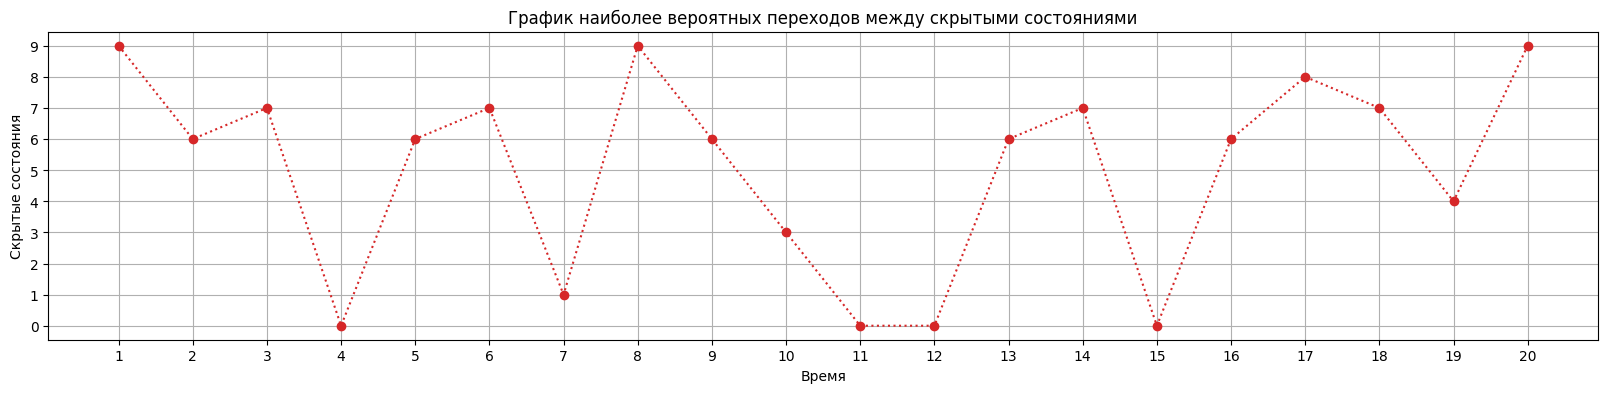

In [ ]:
import matplotlib.pyplot as plt

x = path
y = list(range(N))

positions = range(len(x))

plt.figure(figsize=(20, 4))
plt.plot(positions, x, marker='o', linestyle=':', color='C3')
plt.yticks(ticks=range(len(y)), labels=y)
plt.xticks(ticks=positions, labels=[i+1 for i in positions])

plt.xlabel('Время')
plt.ylabel('Скрытые состояния')
plt.title('График наиболее вероятных переходов между скрытыми состояниями')
plt.grid(True)

plt.show()

## Шаг 3. Forward algorithm: алгоритм прямого хода (подсчет вероятностей последовательностей наблюдений слева направо)
* Forward алгоритм позволяет оценить, насколько вероятна данная последовательность наблюдений $w$, исходя из всех возможных путей через скрытые состояния $s$, без знания конкретного пути.

* В отличие от алгоритма Витерби, здесь в ячейки буду записывать не максимальные вероятности, а сумму всех ранее посчитанных вероятностей (вероятности наблюдать путь до этой ячейки). Для минимизации потерь при вычислениях буду использовать функцию $logsumexp$.

* Для оценки общей вероятности наблюдаемой последовательности сложу все вероятности по всем состояниям в последний момент наблюдения, $L$.

In [10]:
# написала функцию для понимания, что происходит
def log_sum_exp(log_values):
    a = np.max(log_values)
    result = a + np.log(np.sum(np.exp(log_values - a)))
    return result

# примерчик
log_values = np.array([-5, -7])
log_sum = log_sum_exp(log_values)
print(f"log_sum_exp{log_values} = {log_sum}")

log_sum_exp[-5 -7] = -4.873071988957028


In [11]:
def forward(A_log, B_log, E_log, w, N, L):
    f = []
    f1 = [B_log[i] + E_log[i][w[0]] for i in range(N)]
    f.append(f1)

    for l in range(1, L):
        fl = []
        for i in range(N):
            fl_sj = [f[l-1][j] + A_log[j][i] + E_log[i][w[l]] for j in range(N)]
            log_sum = log_sum_exp(fl_sj)
            fl.append(log_sum)
        f.append(fl)

    f = np.array(f)

    P_sum_forward = np.exp(log_sum_exp(f[-1]))

    return f, P_sum_forward

Вероятность последовательности наблюдений $w$ при скрытых состояниях $s$ вычисляется по формуле ([источник](https://logic.pdmi.ras.ru/~sergey/teaching/asr/notes-09-hmm.pdf)):
$$P(w|s) = \sum_{i=1}^{n} i = a_T(i)$$



In [12]:
f, P_sum_forward = forward(A_log, B_log, E_log, w, N, L)
print(f'Вероятность исходной последовательности наблюдений, w: {P_sum_forward}')

Вероятность исходной последовательности наблюдений, w: 6.876893906048347e-24


## Шаг 4. Backward algorithm: алгоритм обратного хода, (подсчет вероятностей последовательностей наблюдений справа налево)
* Backward алгоритм показывает, какова вероятность в $t$ момент времени быть в состоянии $s_i$ c учетом последовательности наблюдений до момента времени $L$ (до конца).
* Конечные состояния инициализируются единичными вероятностями.

In [13]:
def backward(A_log, B_log, E_log, w, N, L):
    b = [None] * L
    b[L-1] = [0.0 for i in range(N)]

    for t in range(L - 2, -1, -1):
        bl = []
        for i in range(N):
            bl_sj = [b[t + 1][j] + A_log[i][j] + E_log[j][w[t + 1]] for j in range(N)]
            log_sum = log_sum_exp(bl_sj)
            bl.append(log_sum)
        b[t] = bl

    b = np.array(b)

    true_P = [b[0][i] + B_log[i] + E_log[i][w[0]] for i in range(N)]
    P_sum_backward = np.exp(log_sum_exp(true_P))

    return b, P_sum_backward

In [14]:
b, P_sum_backward = backward(A_log, B_log, E_log, w, N, L)
print(f'Вероятность исходной последовательности наблюдений, w: {P_sum_backward}')

Вероятность исходной последовательности наблюдений, w: 6.876893906048347e-24


## Промежуточные результаты для рандомной генерации
* Наиболее вероятный путь $w$ по скрытым состояниям.
* Вероятность последовательности наблюдений $w$ при скрытых состояниях $s$.
* График наиболее вероятных переходов между скрытыми состояниями $s$.

 > Можно менять `figsize` в `plt.figure(figsize=(50, 3))`, чтобы график был симпатичнее.


ПОДВЕДЕНИЕ ПРОМЕЖУТОЧНЫХ РЕЗУЛЬТАТОВ


👾 Наиболее вероятный путь (path) по скрытым состояниям (расчитан алгоритмом Viterbi): 

path:
 [9, 6, 7, 0, 6, 7, 1, 9, 6, 3, 0, 0, 6, 7, 0, 6, 8, 7, 4, 9].


👾 Вероятность последовательности наблюдений w при скрытых состояниях s:

Forward algorithm:  1.4302485926999228e-23,

Backward algorithm: 1.4302485926999328e-23, где

   w:
   [3, 6, 3, 9, 10, 3, 12, 1, 2, 0, 6, 5, 6, 3, 4, 2, 13, 9, 5, 14],
   s:
   [0, 0, 0, 2, 0, 2, 6, 8, 3, 0, 6, 6, 3, 0, 9, 9, 9, 1, 6, 4].


👾 График наиболее вероятных переходов между скрытыми состояниями:




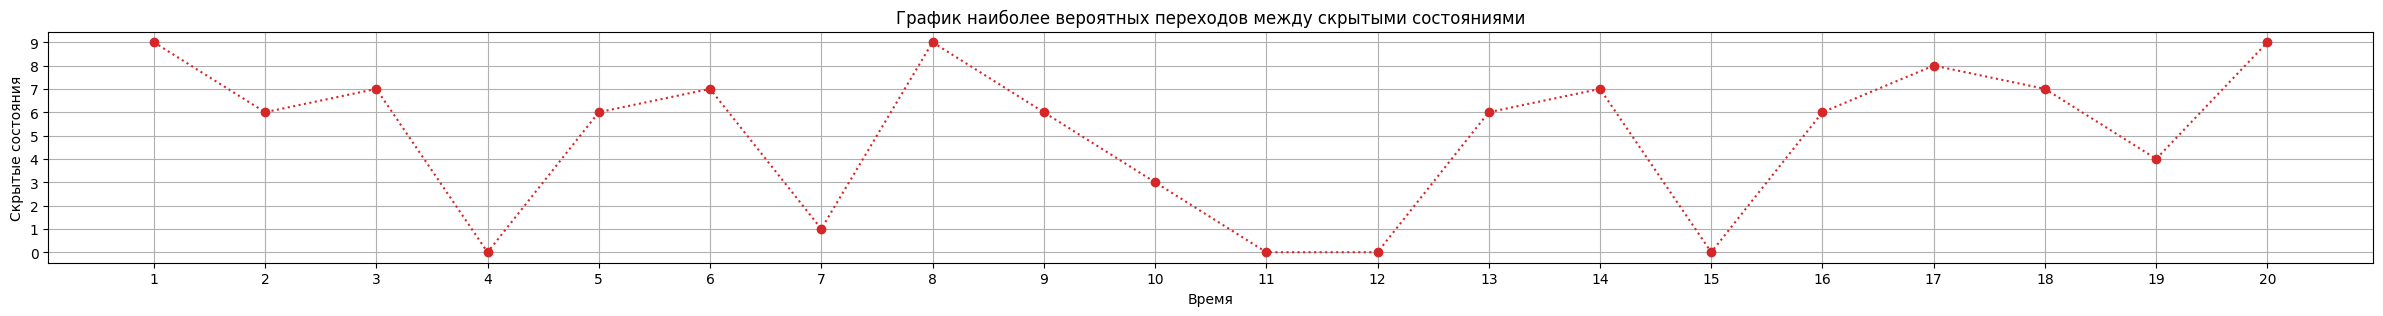

In [ ]:
print('\033[1m\nПОДВЕДЕНИЕ ПРОМЕЖУТОЧНЫХ РЕЗУЛЬТАТОВ\n\n\033[0m')
print(f'👾 \033[1mНаиболее вероятный путь (path) по скрытым состояниям (расчитан алгоритмом Viterbi): \033[0m\n')
print(f'\033[1mpath:\033[0m\n {path}.\n\n')
print(f'👾 \033[1mВероятность последовательности наблюдений w при скрытых состояниях s:\n\033[0m')
print(f'\033[1mForward algorithm:  \033[0m{P_sum_forward},\n')
print(f'\033[1mBackward algorithm: \033[0m{P_sum_backward}, \033[1mгде\033[0m\n')
print(f'\033[1m   w:\n\033[0m   {w},')
print(f'\033[1m   s:\n\033[0m   {s}.\n\n')
print(f'👾 \033[1mГрафик наиболее вероятных переходов между скрытыми состояниями:\n\033[0m\n')

x = path
y = list(range(N))

positions = range(len(x))

plt.figure(figsize=(30, 3))
plt.plot(positions, x, marker='o', linestyle=':', color='C3')
plt.yticks(ticks=range(len(y)), labels=y)
plt.xticks(ticks=positions, labels=[i+1 for i in positions])

plt.xlabel('Время')
plt.ylabel('Скрытые состояния')
plt.title('График наиболее вероятных переходов между скрытыми состояниями')
plt.grid(True)

plt.show()

## Промежуточные результаты для казино

* Наиболее вероятный путь $w$ по скрытым состояниям.
* Вероятность последовательности наблюдений $w$ при скрытых состояниях $s$.
* График наиболее вероятных переходов между скрытыми состояниями $s$.


ПОДВЕДЕНИЕ ИТОГОВ КАЗИНО


👾 Наиболее вероятный путь (path и path_FL) по скрытым состояниям (расчитан алгоритмом Viterbi): 

path:
 [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,

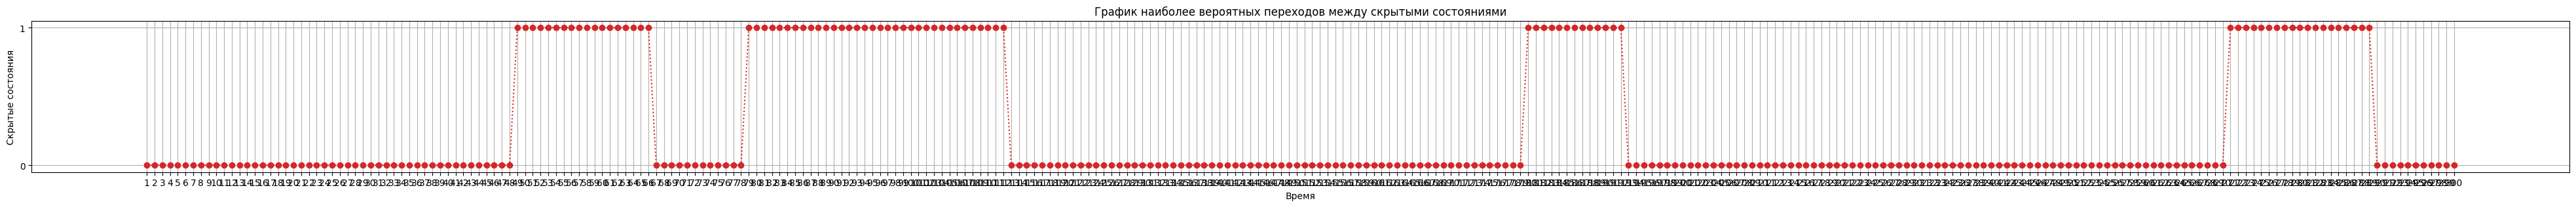



👾 Что делал бы игрок при наиболее вероятной последовательности наблюдений:

- бросал пацанский кубик 216 раз(а),

- бросал аморальный кубик 84 раз(а).


👾 Количество совпадений в реальных и наиболее вероятных скрытых состояниях = 272.


In [ ]:
print('\033[1m\nПОДВЕДЕНИЕ ИТОГОВ КАЗИНО\n\n\033[0m')
print(f'👾 \033[1mНаиболее вероятный путь (path и path_FL) по скрытым состояниям (расчитан алгоритмом Viterbi): \033[0m\n')
print(f'\033[1mpath:\033[0m\n {path}.\n')

# путь не в 0 и 1, а в F и L
def ones_zeros_to_FL(path):

    path_FL = []

    for i in range(len(path)):
        if path[i] == 0:
          path_FL.append('F')
        else:
          path_FL.append('L')
    return path_FL

path_FL = ones_zeros_to_FL(path)
print(f'\033[1mpath_FL:\033[0m\n {path_FL}.\n\n')

print(f'👾 \033[1mВероятность последовательности наблюдений w при скрытых состояниях s:\n\033[0m')
print(f'\033[1mForward algorithm:  \033[0m{P_sum_forward},\n')
print(f'\033[1mBackward algorithm: \033[0m{P_sum_backward}, \033[1mгде\033[0m\n')
print(f'\033[1m   w_given\n\033[0m   {w_given},')
print(f'\033[1m   s_given:\n\033[0m   {s_given}.\n\n')
print(f'👾 \033[1mГрафик наиболее вероятных переходов между скрытыми состояниями:\n\033[0m\n')

# построение графика
x = path
y = list(range(N))

positions = range(len(x))

plt.figure(figsize=(50, 3))
plt.plot(positions, x, marker='o', linestyle=':', color='C3')
plt.yticks(ticks=range(len(y)), labels=y)
plt.xticks(ticks=positions, labels=[i+1 for i in positions])

plt.xlabel('Время')
plt.ylabel('Скрытые состояния')
plt.title('График наиболее вероятных переходов между скрытыми состояниями')
plt.grid(True)

plt.show()


# пацанский и аморальный кубики - сколько раз бросает при наиболее вероятной последовательности наблюдений
zeros_counter = 0
ones_counter = 0

for i in range(len(path)):
    if path[i] == 0:
        zeros_counter += 1
    else:
        ones_counter += 1

print(f'\n\n👾 \033[1mЧто делал бы игрок при наиболее вероятной последовательности наблюдений:\033[0m')
print(f'\n- бросал пацанский кубик \033[1m{zeros_counter}\033[0m раз(а),')
print(f'\n- бросал аморальный кубик \033[1m{ones_counter}\033[0m раз(а).')

a = sum([path[i] == s[i] for i in range(L)])
print(f'\n\n👾 \033[1mКоличество совпадений в реальных и наиболее вероятных скрытых состояниях = \033[0m{a}\033[1m.\033[0m')

##Шаг 5. Апостериорное декодирование
* Алгоритм апостериорного (posterior) декодирования позволяет вычислить вероятность каждого состояния в каждый момент времени, учитывая всю последовательность наблюдений. Это позволяет определить, в каком состоянии находилась система с наибольшей вероятностью в конкретный момент времени.

In [15]:
from scipy.special import logsumexp

In [16]:
def posterior(A_log, E_log, w, N, L, f, b):

    giga_matrix = np.zeros((L - 1, N, N))
    for t in range(L - 1):
        for i in range(N):
            for j in range(N):
                '''
                P_si_now = f[t][i]
                next_trans_from_si_to_sj = A[i][j]
                next_obs_in_sj = E[j][w[t+1]]
                P_sj_next = b[t+1][j]
                '''
                giga_matrix[t][i][j] = f[t][i] + A_log[i][j] + E_log[j][w[t+1]] + b[t+1][j]

    posterior_log = logsumexp(giga_matrix, axis=2) # суммирую по третьей оси (j)
    last_posterior_sum_log = logsumexp(posterior_log[-1]) # перемножаю все вероятности в последний момент времени (L)
    p = np.vstack((posterior_log, [last_posterior_sum_log] * N))
    p_exp = np.exp(p)

    return p, p_exp, giga_matrix

In [17]:
p, p_exp, giga_matrix = posterior(A_log, E_log, w, N, L, f, b)

## График апостериорных вероятности состояний для рандомной генерации
* плюс наиболее вероятный путь по скрытым состояниям $w$ в сравнении с алгоритмом Витерби

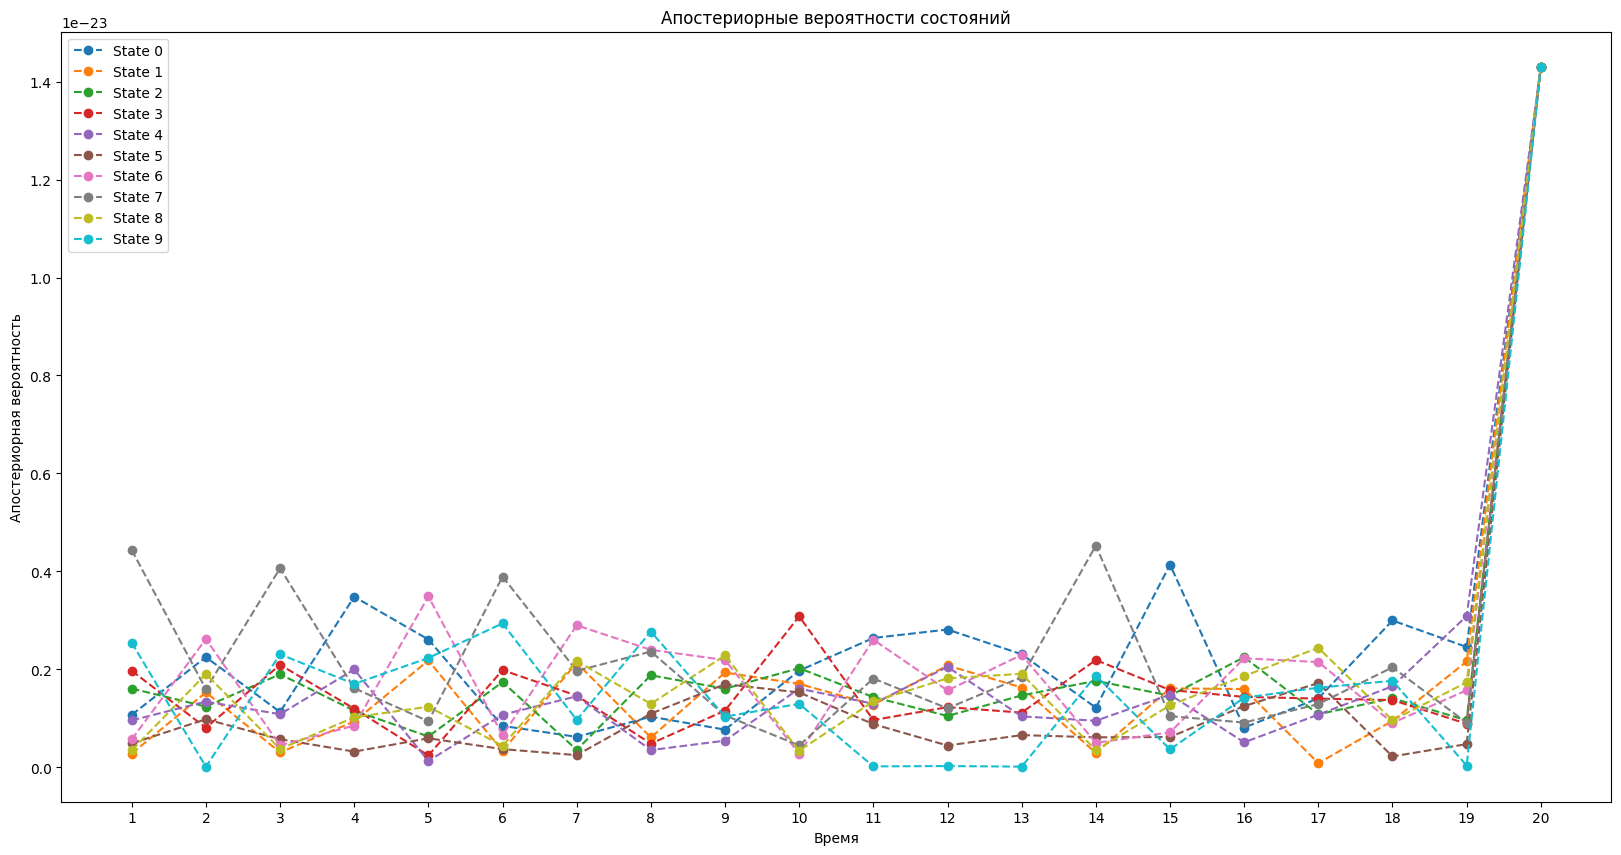

In [ ]:
plt.figure(figsize=(20, 10))

for i in range(N):
    plt.plot(p_exp[:, i],
             marker='o', linestyle='--',
             label=f'State {i}')

plt.xlabel('Время')
plt.ylabel('Апостериорная вероятность')
plt.title('Апостериорные вероятности состояний')

x = range(L)
positions = range(len(x))

plt.xticks(ticks=x, labels=[i+1 for i in positions])

plt.legend()
plt.grid(False)
plt.show()

In [ ]:
states_path = []

for i in range(L):
    states_path.append(np.argmax(p[i]))

In [ ]:
print('Наиболее вероятный путь по скрытым состояниям:\n')
print(f'- алгоритм Витерби\n{path}\n')
print(f'- апостериорное декодирование\n{states_path}')

Наиболее вероятный путь по скрытым состояниям:

- алгоритм Витерби
[9, 6, 7, 0, 6, 7, 1, 9, 6, 3, 0, 0, 6, 7, 0, 6, 8, 7, 4, 9]

- апостериорное декодирование
[7, 6, 7, 0, 6, 7, 6, 9, 8, 3, 0, 0, 0, 7, 0, 2, 8, 0, 4, 0]


## График апостериорных вероятности состояний для казино
* плюс наиболее вероятный путь по скрытым состояниям $w$ в сравнении с алгоритмом Витерби

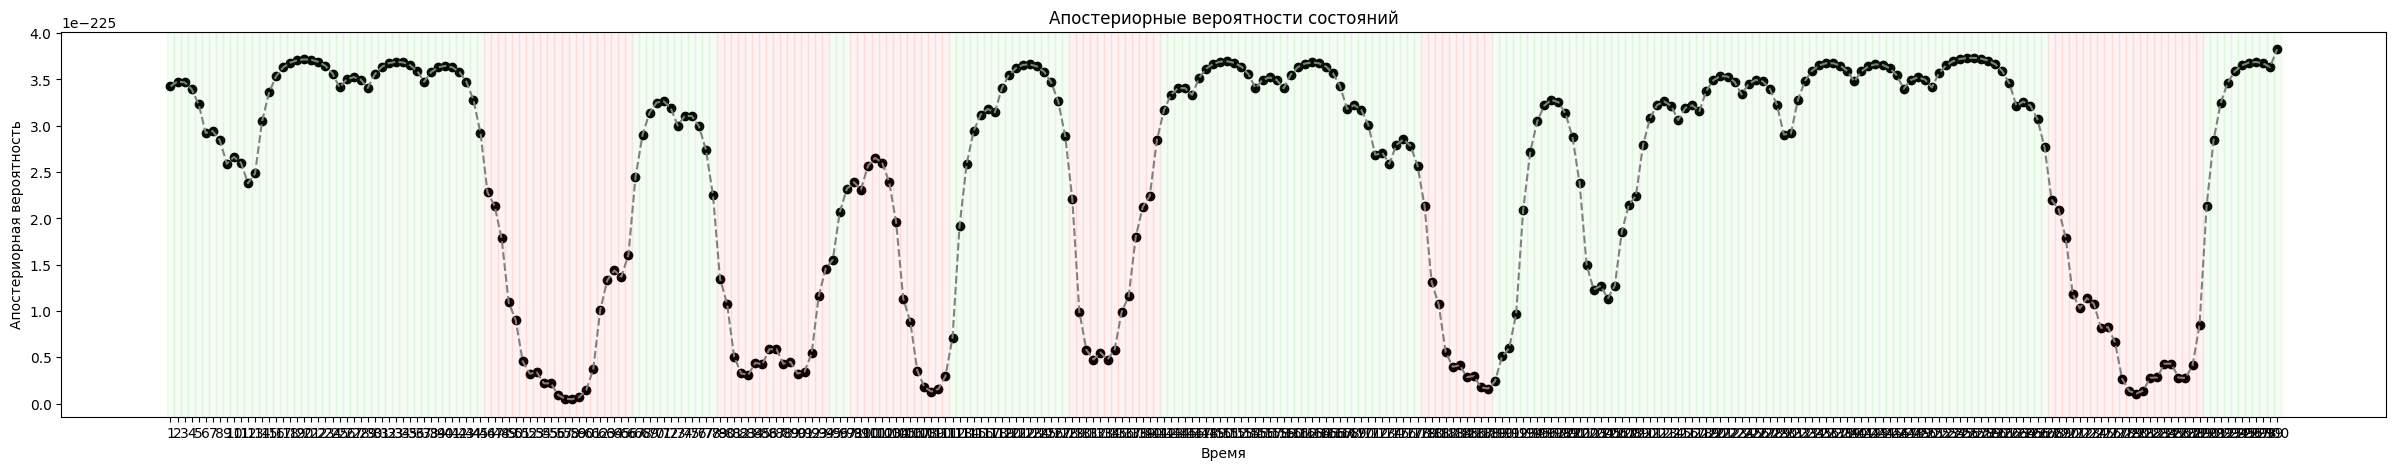

Зеленые полосы - Fair, красные полосы - Loaded.


In [ ]:
plt.figure(figsize=(30, 5))


#colors = ['red' if s[i] == 1 else 'black' for i in range(L)]

x = range(L)

#plt.scatter(x, p_exp[:, 0], c=colors, marker='o', label='Fair')

plt.scatter(x, p_exp[:, 0], color = 'black', marker='o')
plt.plot(x, p_exp[:, 0], linestyle='--', color='gray')

plt.xlabel('Время')
plt.ylabel('Апостериорная вероятность')
plt.title('Апостериорные вероятности состояний')

positions = range(len(x))

plt.xticks(ticks=x, labels=[i+1 for i in positions])

ax = plt.gca()

for i in range(L):
    if s[i] == 1:
        ax.axvspan(i - 0.5, i + 0.5, color='red', alpha=0.05)
    else:
        ax.axvspan(i - 0.5, i + 0.5, color='limegreen', alpha=0.05)

plt.grid(False)
plt.show()

print(f'Зеленые полосы - Fair, красные полосы - Loaded.')

In [ ]:
states_path = []

for i in range(L):
    states_path.append(np.argmax(p[i]))

In [ ]:
print('Наиболее вероятный путь по скрытым состояниям:\n')
print(f'- алгоритм Витерби\n{path}\n')
print(f'- апостериорное декодирование\n{states_path}')

Наиболее вероятный путь по скрытым состояниям:

- алгоритм Витерби
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

- апостериорное декодирование
[

##Алгоритм Баума-Уэлша

* Нет бабушкиной тетради 😭.
* Алгоритм Баума-Уэлша позволяет обновлять исходную матрицу переходов $A$, эмиссионную матрицу $E$ и вектор начального распределения скрытых состояний $B$.
* При этом алгоритм включает в себя использование алгоритмов прямого и обратного хода, а также апостериорное декодирование.
* Здесь же будет выведен результат работы алгоритма (универсальный и для рандомной генерации, и для казино).

In [ ]:
def baum_welch(w, B_log, A_log, E_log, N, L, K, epochs):

    stop_at = 1e-5

    for epoch in range(epochs):

        # Алгоритмы прямого и обратного хода, апостеориорное декодирование
        f, P_sum_forward = forward(A_log, B_log, E_log, w, N, L)
        b, P_sum_backward = backward(A_log, B_log, E_log, w, N, L)
        p, p_exp, giga_matrix = posterior(A_log, E_log, w, N, L, f, b)

        # Новое начальное распределение вероятностей
        B_log = p[0] - logsumexp(p[0])

        if np.any(np.exp(B_log) < stop_at):
            print(f'Остановка алгоритма на {epoch} эпохе.')
            print(f'Одно из значений в начальном распределении вероятностей < {stop_at}.')
            break



        # Новая матрица перехода
        #A_log = logsumexp(giga_matrix, axis=0) - logsumexp(p[-1]).T # схлопнула t, оставила i и j
        A_log = logsumexp(giga_matrix, axis=0) - logsumexp(giga_matrix, axis=(0, 1))

        # Новая эмиссионная матрица

        for j in range(N):
            for k in range(K):

                mask = (np.array(w) == k)

                if np.any(mask) == True:
                    p_selected = p[mask, j]
                    E_log[j][k] = logsumexp(p_selected) - logsumexp(p[:, j])
                else:
                    E_log[j][k] = np.log(0)


    return B_log, A_log, E_log

In [ ]:
B_new_log, A_new_log, E_new_log = baum_welch(w, B_log, A_log, E_log, N, L, K, epochs = 10)

Остановка алгоритма на 3 эпохе.
Одно из значений в начальном распределении вероятностей < 1e-05.


<ipython-input-25-f91a53e0643b>:37: RuntimeWarning: divide by zero encountered in log
  E_log[j][k] = np.log(0)


In [ ]:
print('\033[1mРЕЗУЛЬТАТ АЛГОРИТМА БАУМА-УЭЛША\n\033[0m')

print(f'👾 \033[1mМатрица переходов, A:\033[0m\n')
print(f'\033[1mстарая:\n\033[0m{A},\n')
print(f'\033[1mновая:\n\033[0m{np.exp(A_new_log)}.\n\n')

print(f'👾 \033[1mЭмиссионная матрица, E:\033[0m\n')
print(f'\033[1mстарая:\n\033[0m{E},\n')
print(f'\033[1mновая:\n\033[0m{np.exp(E_new_log)}.\n\n')

print(f'👾 \033[1mНачальное распределение скрытых состояний, B:\033[0m\n')
print(f'\033[1mстарое:\n\033[0m{B},\n')
print(f'\033[1mновое:\n\033[0m{np.exp(B_new_log)}.')

РЕЗУЛЬТАТ АЛГОРИТМА БАУМА-УЭЛША

👾 Матрица переходов, A:

старая:
[[0.17487581 0.08304239 0.17105162 0.14067932 0.0411652  0.03371247
  0.1604003  0.05142945 0.05448145 0.08916198]
 [0.073755   0.12718925 0.1231688  0.12018519 0.07532345 0.07013993
  0.09177673 0.09199362 0.09854404 0.12792398]
 [0.19545207 0.03744834 0.04460988 0.02401731 0.14484585 0.06832593
  0.09919954 0.1965264  0.11929064 0.07028404]
 [0.20084061 0.0122258  0.06978382 0.15165796 0.06737472 0.10195862
  0.20310494 0.0995903  0.04121911 0.05224412]
 [0.16070004 0.11061639 0.02432858 0.01713972 0.13879937 0.01059406
  0.0639687  0.11613338 0.17763705 0.1800827 ]
 [0.18293459 0.10646337 0.16932829 0.07266122 0.03695301 0.15802639
  0.02332103 0.00901296 0.08257955 0.15871959]
 [0.07699418 0.08459161 0.09799422 0.14548637 0.08024913 0.0463639
  0.11764649 0.16240991 0.17173868 0.01652552]
 [0.12680456 0.11926721 0.10548648 0.07744466 0.08804995 0.12032238
  0.09758039 0.10606245 0.13103687 0.02794506]
 [0.11497741 0.